In [1]:
from proba_contextfg import get_all_trees, build_pcfg
from utils import read_file, write_file, compute_precision
from sklearn.model_selection import train_test_split
from out_of_vocab import OOV_module
from proba_cyk import PCKY
import numpy as np
from nltk import Tree
import warnings
warnings.simplefilter('ignore')

mode = 'test' #mode = 'eval' pour l'évaluation avec de nouvelles phrases
path_grammar = 'sequoia-corpus+fct.mrg_strict'
path_embeddings = 'polyglot-fr.pkl'
grammars = read_file(path_grammar)
grammars_train, grammars_test = train_test_split(grammars, test_size=0.1, shuffle=False) 
tree_cfg_grammars = get_all_trees(grammars_train)
corpus = [' '.join(tree.leaves()) for tree in tree_cfg_grammars]
axiomes, lexicons, dico_lexicons, dico_cfg = build_pcfg(tree_cfg_grammars)
## Construction d'un modèle CYK
oov = OOV_module(path_embeddings = path_embeddings, 
                 lexicons=lexicons, corpus = corpus)
## Construction des dictionnaires contenant 
## les probabilités associés au unigrams et bigrams du Corpus
oov.build_unigram_bigram()
## Probabilistc CKY
pcky = PCKY(oov=oov, dico_lexicons=dico_lexicons,
            dico_cfg=dico_cfg, axiomes=axiomes, 
            lexicons=lexicons)

In [18]:
## precision/score en fonction de la taille de la phrase
import pandas as pd
def get_df(corpus, predictions_train, status, grammars_train):
    df = pd.DataFrame([len(sent.split()) for sent in corpus], columns =['taille'])
    df['nb moyen succes'] = status
    df['precision moyenne'] = [compute_precision([predictions_train[i]], 
                          [grammars_train[i]]) for i in range(len(corpus))]
    df['nb OOV'] = [len([elt for elt in sent.split() if elt.lower() not in lexicons]) for sent in corpus]
    return df

In [8]:
predictions_train = [pcky.induce_CYK(sentence, show=True) for sentence in corpus[:300]]
status, predictions_train_ = [x[1] for x in predictions_train], [x[0] for x in predictions_train]

In [9]:
print('Precision on test with all :', compute_precision(predictions_train, grammars_train[:300]))
print('Precision on test with success only', compute_precision(predictions_train, grammars_train[:300])* len(grammars_train[:300])/sum(status))

Precision on test with all : 0.8407724399755201
Precision on test with success only 0.8407724399755201


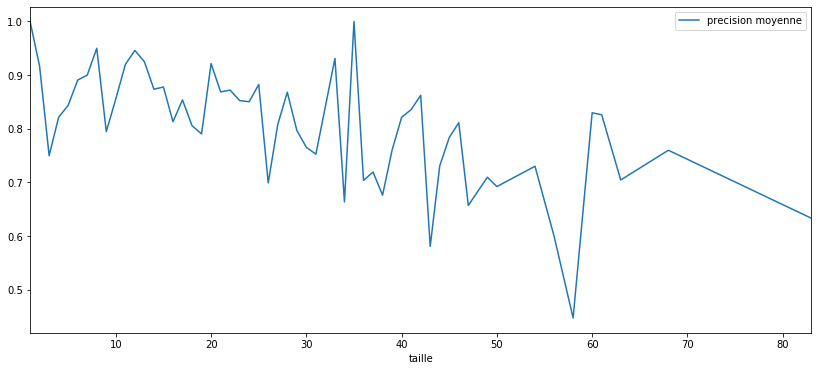

In [10]:
df_tmp = get_df(corpus[:300], predictions_train, status, grammars_train[:300])
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize = (14, 6))
df_tmp.groupby('taille').mean().reset_index().plot(x="taille", 
                                               y=["precision moyenne"], kind='line', ax = ax);

In [68]:
cfg_test = get_all_trees(grammars_test)
corpus_test = [' '.join(tree.leaves()) for tree in cfg_test]
predictions_test =[]
for i, sentence in enumerate(corpus_test) :
    predictions_test.append(pcky.induce_CYK(sentence, show=True))
    if i%10 == 0:
        print("sentence :", i)
status_test, predictions_test_ = [x[1] for x in predictions_test], [x[0] for x in predictions_test]

The sentence : ### - 19 janvier 2004 : le juge Armand Riberolles clôt ses investigations et l' instruction de l' affaire des HLM de Paris . ### is not recognized.
We hope you meant : ### - 19 janvier 2004 : le juge armand riberolles cent ses investigations et l' instruction de l' affaire des hlm de paris . ###
sentence : 0
The sentence : ### - Février 2005 : le parquet de Paris requiert un non- lieu en_faveur_de Jean Tiberi , accordé par le juge Armand Riberolles . ### is not recognized.
We hope you meant : ### - février 2005 : le parquet de paris acquiert un non- lieu en_faveur_de jean tiberi , accordé par le juge armand riberolles . ###
The sentence : ### - Juin 2005 : l' ex- conseiller général RPR des Hauts-de-Seine Didier Schuller et le député-maire -LRB- UMP -RRB- de Levallois-Perret Patrick Balkany comparaissent devant le tribunal correctionnel de Créteil dans l' affaire des HLM des Hauts-de-Seine . ### is not recognized.
We hope you meant : ### - juin 2005 : l' ex- conseiller gé

The sentence : ### Collusions maçonniques ### is not recognized.
We hope you meant : ### commissions maçonnerie ###
The sentence : ### Comme dans d'_autres affaires politico- financières françaises des années 1990 , plusieurs protagonistes de cette affaire appartiennent à des loges maçonniques : Jean-Claude Méry , Jacky Chaisaz , Didier Schuller -LRB- loge Silence de la GLNF -RRB- . ### is not recognized.
We hope you meant : ### comme dans d'_autres affaires politico- financières françaises des années 1990 , plusieurs protagonistes de cette affaire appartiennent à des loges maçonnerie : jean-claude méry , jacky chaisaz , didier schuller -lrb- loge silence de la fief -rrb- . ###
The sentence : ### - HLM de Paris : les seuls patrons du bâtiment à la barre - Libération - 23/12/2006 ### is not recognized.
We hope you meant : ### - hlm de paris : les seuls pons du bâtiment à la marge - libération - OOV ###
sentence : 30
The sentence : ### Rassemblement pour la République . ### is not recogn

The sentence : ### Jacques Chirac affirme que cette somme , qui n' apparaît pas dans sa déclaration de patrimoine , provient des fonds spéciaux conservés lorsqu' il était Premier ministre . ### is not recognized.
We hope you meant : ### jacques chirac attire que cette somme , qui n' apparaît pas dans sa déclaration de patron , provient des fonds légaux contesté lorsqu' il était premier ministre . ###
The sentence : ### Aucun lien n' a pu être établi entre ces espèces et l' argent de la corruption des marchés d' Île-de-France . ### is not recognized.
We hope you meant : ### aucun lien n' a pu être établi entre ces secrètes et l' argent de la corruption des marchés d' ile-de-france . ###
The sentence : ### Selon le procureur Jean-Pierre Dintilhac , rien ne s' opposait à une audition de Jacques Chirac comme témoin assisté dans cette affaire . ### is not recognized.
We hope you meant : ### selon le procureur jean-pierre réveilhac , rien ne s' opposait à une audition de jacques chirac comme

The sentence : ### Le procès doit s' étaler sur cinq semaines , jusqu'_au 22 novembre 2006 , à_raison_de deux jours d' audience par semaine en_moyenne . ### is not recognized.
We hope you meant : ### le procès doit s' étage sur cinq semaines , jusqu'_au 22 novembre 2006 , à_raison_de deux jours d' audience par semaine en_moyenne . ###
The sentence : ### L' audience d' appel survient après la nomination par Jacques Chirac le 13 septembre 2006 d' un de ses anciens conseillers , Laurent Le Mesle , au poste de procureur général de Paris . ### is not recognized.
We hope you meant : ### l' audience d' appel survient après la nomination par jacques chirac le 13 septembre 2006 d' un de ses anciens conseillers , laurent le masse , au poste de procureur général de paris . ###
The sentence : ### Ce magistrat ne sera pas physiquement présent à l' audience mais sera en position de dicter les réquisitions au magistrat chargé du procès . ### is not recognized.
We hope you meant : ### ce magistrat ne 

The sentence : ### Les clubs italiens font appel . ### is not recognized.
We hope you meant : ### les clubs citations font appel . ###
The sentence : ### Ils mettent en_avant le manque de témoignages les concernant . ### is not recognized.
We hope you meant : ### ils mettent vivant le manque de témoignages les concernant . ###
The sentence : ### Le 25 juillet , contrairement_à ce que demandait le procureur Stefano Palazzi qui souhaitait une aggravation des peines , la cour fédérale d' appel de la justice sportive les revoit à la baisse . ### is not recognized.
We hope you meant : ### le 25 juillet , OOV ce que mandat le procureur tenant placé qui souhaitait une ségrégation des peines , la cour fédérale d' appel de la justice prive les reçut à la baisse . ###
The sentence : ### La Juve est finalement le seul club relégué et le Milan AC , pénalisé de 30 points , passe de la seconde à la quatrième place et participera au tour préliminaire de la Ligue des Champions . ### is not recognized.

The sentence : ### Rebondissement ### is not recognized.
We hope you meant : ### arrondissements ###
The sentence : ### Le 13 janvier 2002 , à quelques semaines des élections présidentielles , une note de la DST , mystérieusement rendue publique -LRB- après un article de L' Est républicain -RRB- , indique que la libération des otages français au Liban -LRB- 1985-1988 -RRB- avait fait l' objet d' un paiement de rançon , ainsi_que d' un système de " rétro- commissions " qui aurait profité à Jean-Charles Marchiani et Charles Pasqua . ### is not recognized.
We hope you meant : ### le 13 janvier 2002 , à quelques semaines des élections prudentielle , une note de la dst , mystérieusement rendue publique -lrb- après un article de l' est républicain -rrb- , indique que la libération des douanes français au vivant -lrb- 1900-1904 -rrb- avait fait l' objet d' un paiement de lafon , ainsi_que d' un système de " rétro- commissions " qui aurait profité à jean-claude maréchal et charles pasqua . ###

The sentence : ### Alors , à qui profite le crime ? ### is not recognized.
We hope you meant : ### alors , à qui préfère le croire ? ###
The sentence : ### La droite crie au scandale et affirme que c' est Chirac que l'_on cherche à atteindre au travers de son ministre de l' Intérieur de l' époque . ### is not recognized.
We hope you meant : ### la droite éric au scandale et attire que c' est chirac que l'_on cherchent à atteindre au traversée de son ministre de l' intérieur de l' époque . ###
sentence : 180
The sentence : ### Charles Pasqua accuse même Jospin d' avoir créé un " cabinet noir " , voué à déstabiliser la droite . ### is not recognized.
We hope you meant : ### charles pasqua occulte même jospin d' avoir créé un " cabinet noir " , nous à déstabilise la droite . ###
The sentence : ### Le Canard enchaîné " verrait bien l' intérêt de Chevènement , ou de Villiers , qui chassent sur les mêmes terres que Pasqua " , avant_de conclure que " ni l' un ni l' autre ne disposaient des mo

The sentence : ### Il fait partie de l' équipe de photographes engagés par Reuters pour couvrir le conflit israélo- libanais de 2006 . ### is not recognized.
We hope you meant : ### il fait partie de l' équipe de photographies engagés par futurs pour couvrir le conflit salon taiwanaise de 2006 . ###
The sentence : ### Les photos incriminées ### is not recognized.
We hope you meant : ### les photos acheminées ###
The sentence : ### Plusieurs clichés de ce photographe sont particulièrement dénoncées au début du mois d' août 2006 , comme ayant subi d' importantes retouches ou des mises en scène [ 2 ] . ### is not recognized.
We hope you meant : ### plusieurs clichés de ce paragraphe sont particulièrement prononcés au début du mois d' août 2006 , comme ayant subi d' importantes rocher ou des mises en scène [ 2 ] . ###
The sentence : ### D'_après les commentaires les accompagnant dans leur publication par Reuters , il_y_a notamment deux clichés du même immeuble , datés respectivement du 24 

The sentence : ### - -LRB- fr -RRB- Opinion : " L' affaire Adnan Hajj : première manipulation emblématique de l' ère numérique " par Andre Gunthert for ARHV , 8 août 2006 ### is not recognized.
We hope you meant : ### - -lrb- fr -rrb- opinion : " l' affaire armand paul : première manipulation systématique de l' mr numérique " par andrew montfort for rh , 8 août 2006 ###
The sentence : ### - -LRB- fr -RRB- " La guerre des images " -LRB- avec une explication des modifications -RRB- par Alain Korkos , La Boite à Images , 8 septembre 2006 ### is not recognized.
We hope you meant : ### - -lrb- fr -rrb- " la guerre des images " -lrb- avec une implication des modifications -rrb- par alain kross , la noire à images , 8 septembre 2006 ###
The sentence : ### - -LRB- en -RRB- Cox & Forkum dession politique à_propos_de la controverse , 7 août 2006 ### is not recognized.
We hope you meant : ### - -lrb- en -rrb- cnd & forum dessaisi politique à_propos_du la containers , 7 août 2006 ###
The sentence 

The sentence : ### René Mayer , Président du Conseil , y mit fin en 1953 en ramenant le taux des piastres à 10 francs , un cours plus réaliste , mais ce en violation des accords du 8 Mars 1949 et des accords de Pau de 1950 ; les États associés du Cambodge , Laos et Viêtnam ne furent pas consultés . ### is not recognized.
We hope you meant : ### rené mer , président du conseil , y met fin en 1953 en ramener le taux des pistes à 10 francs , un cours plus réaliste , mais ce en révolution des accords du 8 mars 1989 et des accords de paul de 1950 ; les états associés du codée , avs et vivant ne furent pas conduites . ###
The sentence : ### Le 12 février 1953 , l' OIC imposa aux banques le recours au crédit documentaire pour le règlement des importations provenant de l' Union française . ### is not recognized.
We hope you meant : ### le 12 février 1953 , l' éric imbot aux banques le recours au crédit commentaires pour le règlement des importations provenant de l' union française . ###
The se

In [73]:
sum(status_test)

195

In [12]:
print('Precision on test with all :', compute_precision(predictions_test, grammars_test))
print('Precision on test with success only', compute_precision(predictions_test, grammars_test)* len(grammars_test)/sum(status_test))

Precision on test with all : 0.3931470884888885
Precision on test with success only 0.6482744544231672


In [70]:
df = get_df(corpus_test, predictions_test, status_test, grammars_test)

In [71]:
df.groupby('nb moyen succes').mean()

,taille,precision moyenne,nb OOV
nb moyen succes,,,
0,24.826087,0.000000,4.547826
1,18.389744,0.615652,2.461538


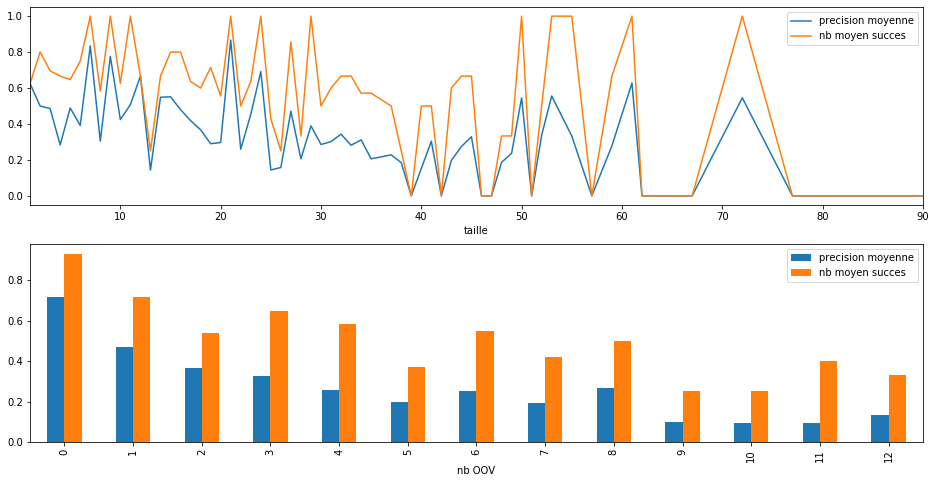

In [72]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 1, figsize = (16, 8))
df.groupby('taille').mean().reset_index().plot(x="taille", 
                                               y=["precision moyenne", "nb moyen succes"], 
                                               kind='line', ax = ax[0]);
df.groupby('nb OOV').mean().reset_index().plot(x="nb OOV", 
                                              y=["precision moyenne", "nb moyen succes"],
                                              kind='bar', ax = ax[1]);
plt.savefig('evaluation.png')